# Postprocess convective ABL case

In [1]:
%%capture 
import sys, os, shutil
postproamrwinddir = '~/src/amr-wind-frontend/'
if postproamrwinddir not in sys.path:
    sys.path.append(postproamrwinddir)
# Load the libraries
import matplotlib.pyplot as plt
import postproamrwindabl as ppabl
import numpy             as np
from matplotlib import cm
import re
import time
import pandas as pd
import xarray as xr

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
def plotrotorlines(zhh, rotorD, xstart, xend, **kwargs):
    plt.hlines(zhh,             xstart, xend, linewidth=1.0, **kwargs) # Plot the HH line
    plt.hlines(zhh+rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line
    plt.hlines(zhh-rotorD*0.5,  xstart, xend, linewidth=0.5, **kwargs) # Plot the HH line    
    
def savecsvdata(d, savekeys, filename):
    # Create a new dictionary
    dfcsv = pd.DataFrame()
    for newkey,oldkey in savekeys.items():
        dfcsv[newkey] = d[oldkey]
    dfcsv.to_csv(filename,index=False,sep=',')
    return

def plot_profile(var,df,avgt):
    returndict = {}
    temp_dict = {}
    prof = ppabl.CalculatedProfile.fromdict(ppabl.statsprofiles[var],df,temp_dict,avgt=avgt)
    z, plotdat = prof.calculate()
    returndict[ppabl.statsprofiles[var]['header']] = {'z':z, 'data':plotdat}
    return returndict 

In [3]:
rundir='/gpfs/lcheung/HFM/exawind-benchmarks/convective_abl/'
resultsdir='../results/'
casenames = [
    'AMR-Wind, t=[15000,20000]'
]
caseparams = {}
caseparams[casenames[0]] = {'rundir':rundir, 'saveprefix':'avgprofile_5000s','ncfile':'post_processing/abl_statistics30000.nc', 'avgtimes':[15000,20000],'lstyle':{'color':'tab:blue',}}

# Hub-height locations
zHH_target    = 90.0
rotorD        = 126
bottom_tip    = zHH_target - 0.5*rotorD
top_tip       = zHH_target + 0.5*rotorD

plotheights=[zHH_target]

loadinmemory = False   # Do this only if there's enough RAM and for new (python 3+ netCDF4) libraries



In [4]:
dfs = {}
for case in casenames:
    print("Case: ",case)
    file = caseparams[case]['rundir'] + '/' + caseparams[case]['ncfile']
    df = ppabl.loadnetcdffile(caseparams[case]['rundir']+'/'+caseparams[case]['ncfile'], usemmap=loadinmemory)
    report = ppabl.printReport(df,avgt=caseparams[case]['avgtimes'], heights=plotheights,span=(bottom_tip,top_tip))
    dfs[case] = {}
    dfs[case]['df'] = df
    dfs[case]['report'] = report

Case:  AMR-Wind, t=[15000,20000]
Loading u'u'_r
Loading u
Loading v'v'_r
Loading w'theta'_r
Loading w'w'_r
Loading theta
Loading v
        z       Uhoriz      WindDir       TI_TKE     TI_horiz        Alpha    Alpha-Fit     ObukhovL         Veer     Veer-Fit 
      ===         ====         ====         ====         ====         ====         ====         ====         ====         ==== 
    90.00 1.139983e+01 2.400028e+02 6.173801e-02 9.830029e-02 8.154171e-02 9.446530e-02 -2.017924e+03 6.082818e-04 1.515664e-03 

ustar: 0.468587
zi: 803.132957


## Plot velocity profile

Loading u
Loading v


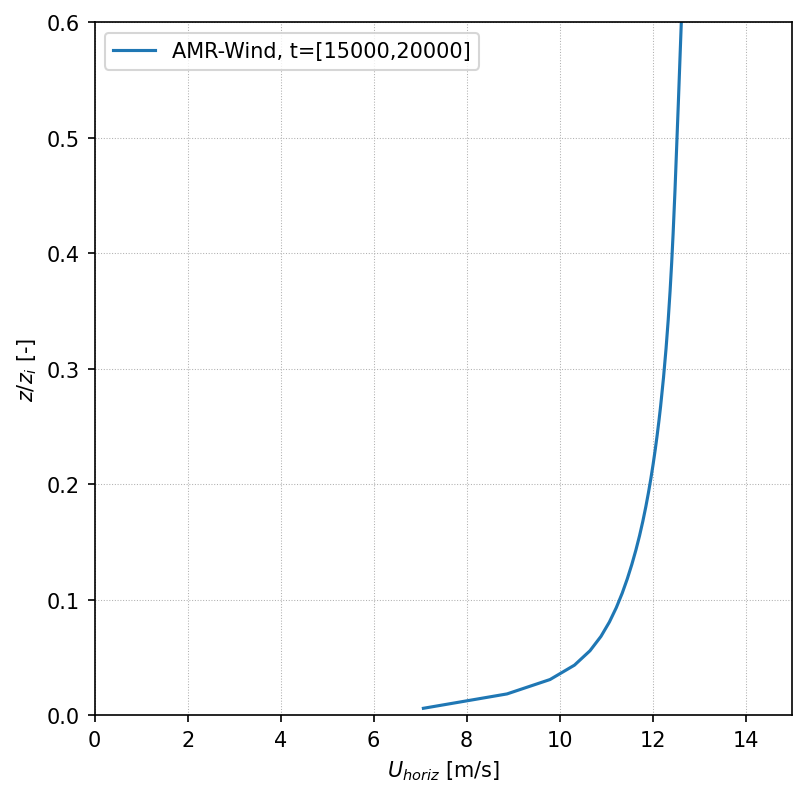

In [5]:
# Plot velocity
var='Uhoriz'
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)

# Plot the turbine dimensions
plotrotorlines(zHH_target, rotorD, 0, 14, linestyles='dashed', color='gray',)

ax.legend()
ax.set_xlim([0, 15])
ax.set_ylim([0, 0.6])
ax.set_xlabel('$U_{horiz}$ [m/s]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_Uhoriz.png")


## Plot temperature profiles

Loading theta


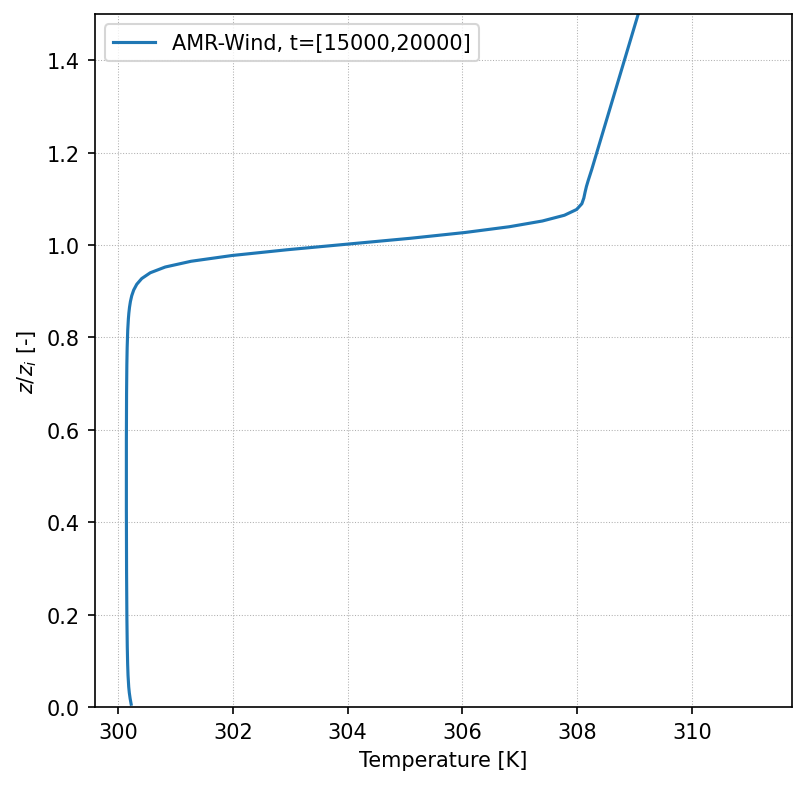

In [6]:
var = ('Temperature','T')
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var[0],df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var[1]]['data'], amrdat[var[1]]['z']/report['zi'], label=case,**lstyle)

ax.legend()
#ax.set_xlim([290, 294])
ax.set_ylim([0, 1.5])
ax.set_xlabel(var[0] + ' [K]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_T.png")

## Plot veer profile

Loading u
Loading v


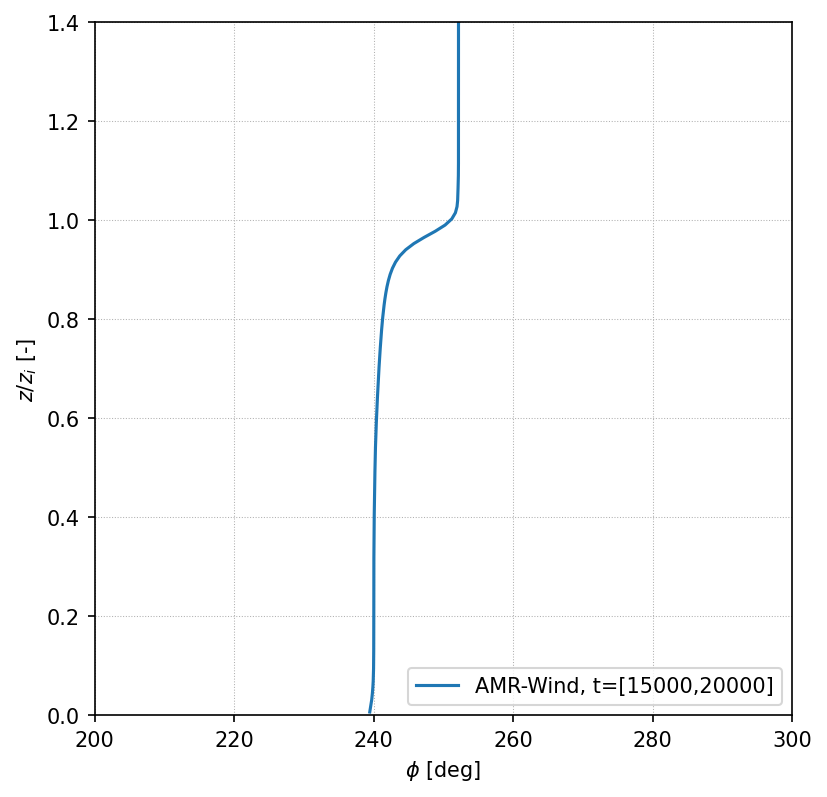

In [7]:
var='WindDir'
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
ax.legend()
ax.set_xlim([200, 300])
ax.set_ylim([0, 1.4])
ax.set_xlabel('$\phi$ [deg]')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_WindDir.png")


## Plot TI

Loading u


Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


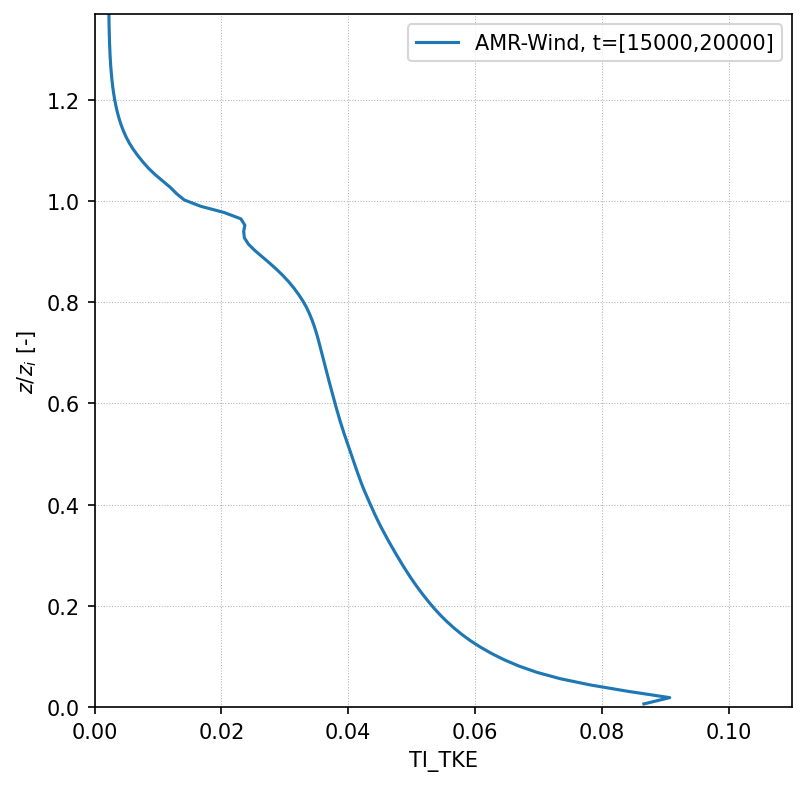

In [8]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
var = 'TI_TKE'
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    lstyle=caseparams[case]['lstyle']
    plt.plot(amrdat[var]['data'], amrdat[var]['z']/report['zi'], label=case,**lstyle)
ax.legend()
plt.ylim([0, 1100/report['zi']])
plt.xlim([0, .11])
ax.set_xlabel('TI_TKE')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_TI.png")

## Plot Reynolds stresses

Loading u'u'_r
Loading u'v'_r
Loading u'w'_r
Loading v'v'_r
Loading v'w'_r
Loading w'w'_r


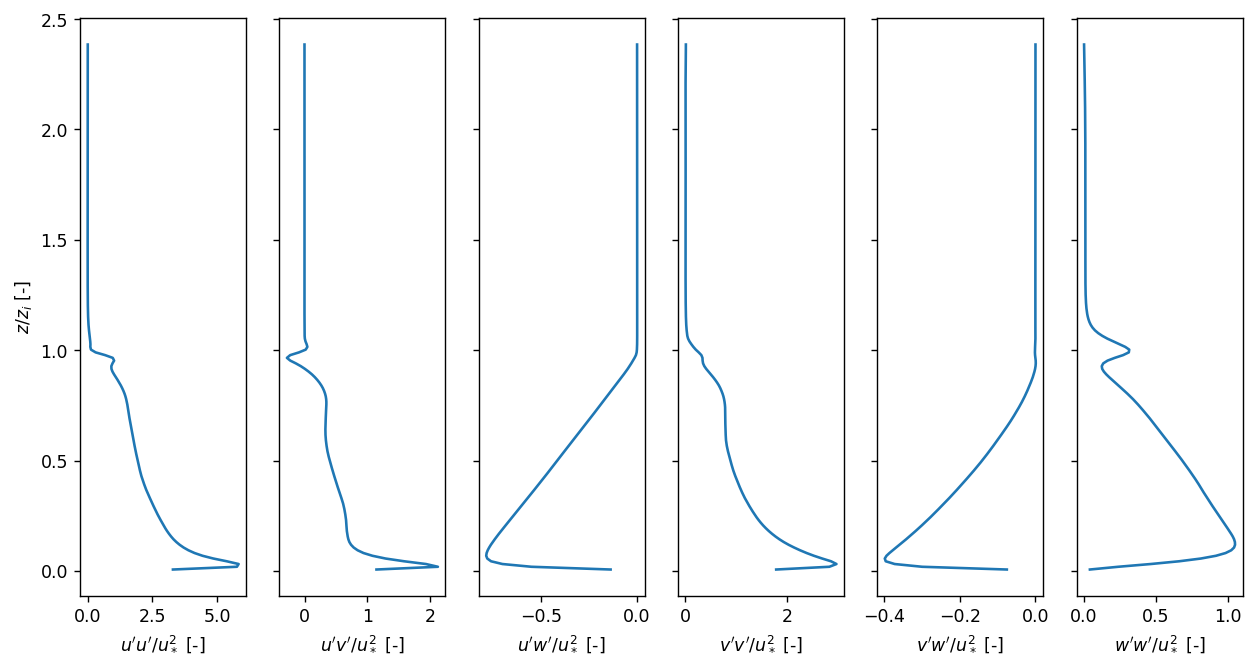

In [9]:
var = 'ReStresses'
#fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
fig, axs = plt.subplots(1, 6,figsize=(12,6), facecolor='w', dpi=125, sharey=True)
plotlabels = ['$u\'u\'$', '$u\'v\'$', '$u\'w\'$','$v\'v\'$','$v\'w\'$','$w\'w\'$']
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    for i in range(6):
        ax = axs[i]
        plt.sca(ax)
        #uw = amrdat['uu uv uw vv vw ww']['data'][:,2]
        re = amrdat['uu uv uw vv vw ww']['data'][:,i]
        ustar = report['ustar']
        z = amrdat['uu uv uw vv vw ww']['z']
        lstyle=caseparams[case]['lstyle']
        plt.plot(re/ustar**2, z/report['zi'],**lstyle)
        ax.set_xlabel(plotlabels[i] + '$/u_*^2$ [-]')
axs[0].set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_RE.png")

## Plot temperature fluxes

Loading u'theta'_r
Loading v'theta'_r
Loading w'theta'_r


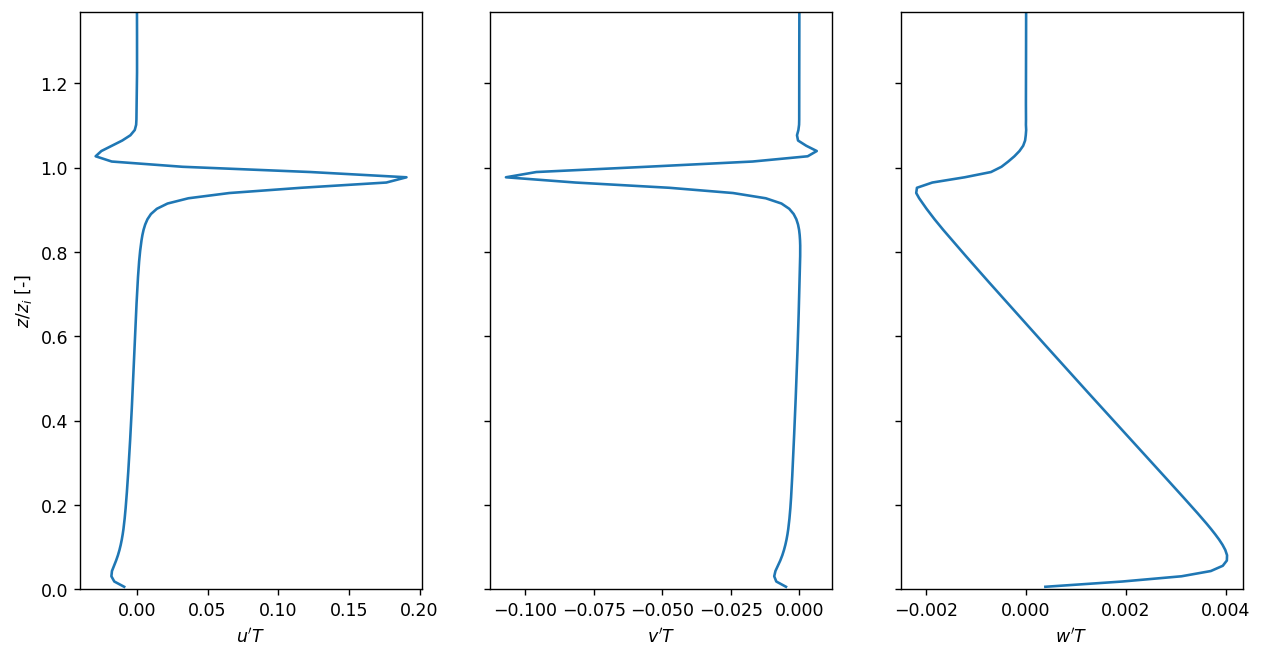

In [10]:
var = 'Tfluxes'
#fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
fig, axs = plt.subplots(1, 3,figsize=(12,6), facecolor='w', dpi=125, sharey=True)
plotlabels = ['$u\'T$', '$v\'T$', '$w\'T$',]
for case in casenames[0:1]:
    df = dfs[case]['df']
    report = dfs[case]['report']
    amrdat = plot_profile(var,df,caseparams[case]['avgtimes'])
    for i in range(3):
        ax = axs[i]
        plt.sca(ax)
        #uw = amrdat['uu uv uw vv vw ww']['data'][:,2]
        re = amrdat['uT vT wT']['data'][:,i]
        ustar = report['ustar']
        z = amrdat['uT vT wT']['z']
        lstyle=caseparams[case]['lstyle']
        plt.plot(re, z/report['zi'],**lstyle)
        ax.set_xlabel(plotlabels[i])
        plt.ylim([0, 1100/report['zi']])
axs[0].set_ylabel('$z/z_i$ [-]')
plt.savefig("./figures/AVG_horiz_profiles_uT.png")